In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import k_hop_subgraph
import torch_geometric
import os
import numpy as np
import torch
from torch.distributions.distribution import Distribution
from scipy.stats import gaussian_kde
import tqdm
from KDEpy import FFTKDE
from torch_sparse import spspmm
from torch_scatter import scatter_add,scatter_sum
import matplotlib.pyplot as plt
import scipy
import pickle

# summary of datasets

In [2]:
DataName=['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']
summary={name:{} for name in DataName}
for name in DataName:
    dataset = TUDataset(os.path.join('../ex_graph/data',name), name=name, use_node_attr=True)
    summary[name]['G']=dataset.data.y.shape[0]
    summary[name]['V']=dataset.data.x.shape[0]
    summary[name]['E']=dataset.data.edge_index.shape[1]/2
    summary[name]['avgV']='{:.4f}'.format(summary[name]['V']/summary[name]['G'])
    summary[name]['avgE']='{:.4f}'.format(summary[name]['E']/summary[name]['V'])
    summary[name]['F']=dataset.data.x.shape[1]
    summary[name]['C']=len(set(dataset.data.y.numpy()))

In [3]:
summary

{'PROTEINS': {'G': 1113,
  'V': 43471,
  'E': 81044.0,
  'avgV': '39.0575',
  'avgE': '1.8643',
  'F': 4,
  'C': 2},
 'DD': {'G': 1178,
  'V': 334925,
  'E': 843046.0,
  'avgV': '284.3166',
  'avgE': '2.5171',
  'F': 89,
  'C': 2},
 'NCI1': {'G': 4110,
  'V': 122747,
  'E': 132753.0,
  'avgV': '29.8655',
  'avgE': '1.0815',
  'F': 37,
  'C': 2},
 'NCI109': {'G': 4127,
  'V': 122494,
  'E': 132604.0,
  'avgV': '29.6811',
  'avgE': '1.0825',
  'F': 38,
  'C': 2},
 'Mutagenicity': {'G': 4337,
  'V': 131488,
  'E': 133447.0,
  'avgV': '30.3177',
  'avgE': '1.0149',
  'F': 14,
  'C': 2},
 'ENZYMES': {'G': 600,
  'V': 19580,
  'E': 37282.0,
  'avgV': '32.6333',
  'avgE': '1.9041',
  'F': 21,
  'C': 6},
 'FRANKENSTEIN': {'G': 4337,
  'V': 73283,
  'E': 77534.0,
  'avgV': '16.8972',
  'avgE': '1.0580',
  'F': 780,
  'C': 2}}

# $H^{(k)}_c$

- input: $ G(X,E), k $
- output: $ H^{(k)}_c $ for all $c$

## estimate $G_c$

In [2]:
def estimate_P(support,x):
    kde0=gaussian_kde(support,bw_method='silverman') # silverman  scott
    value,freq=np.unique(support,return_counts=True)
    kde=gaussian_kde(value,bw_method=kde0.factor,weights=freq)
    P=kde(x)
    return P

def get_P(
                DataName=['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN'],
                N_feature=[4,89,37,38,14,21,780],
                batch_size=32
            ):
    '''
    ['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']
    '''
    P_dataset={dataname:None for dataname in DataName}
    
    for i in range(len(DataName)):
        dataset = TUDataset(os.path.join('data',DataName[i]), name=DataName[i], use_node_attr=True)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        X,edge_index,node_batch,edge_batch=[],[],[],[]
        for b,data in enumerate(train_loader):
            X.append(data.x)
            edge_index.append(data.edge_index)
            node_batch.append(torch.zeros(data.x.shape[0])+b)
            edge_batch.append(torch.zeros(data.edge_index.shape[1])+b)
        X=torch.vstack(X)
        edge_index=torch.hstack(edge_index)
        node_batch=torch.hstack(node_batch)
        edge_batch=torch.hstack(edge_batch)
        
        P_all=None
        use_channel=[]
        for channel in tqdm.tqdm(range(N_feature[i])):
            x=X[:,channel]
            if torch.unique(x).shape[0]==1:
                continue
            use_channel.append(channel)
            P=estimate_P(x,x)
            P=torch.tensor(P.reshape(-1,1))
            if P_all is None:
                P_all=P
            else:
                P_all=torch.hstack([P_all,P])
                
        P_all[P_all.isnan()]=0
        P_dataset[DataName[i]]=(P_all,edge_index,node_batch,edge_batch,use_channel)
    return P_dataset

In [3]:
if not os.path.exists('P_dataset.pkl'):
    P_dataset=get_P()
    pickle.dump(P_dataset, open('P_dataset.pkl', 'wb'))
else:
    P_dataset=pickle.load(open('P_dataset.pkl', 'rb'))

In [4]:
P2=pickle.load(open('P_dataset_backup.pkl', 'rb'))

## $H^{(k)}_{i,c}$

In [4]:
import torch
import torch.nn as nn
from scipy.stats import gaussian_kde
import numpy as np

In [5]:
from torch_geometric.nn.conv import MessagePassing

class EntropyGCN(MessagePassing):
    def __init__(self,normalize=True):
        super(EntropyGCN, self).__init__(aggr='add')
        self.normalize=normalize

    def forward(self, P, edge_index,k):
        n,c_in=P.shape
        edge_index_raw=edge_index
        for i in range(0,k-1):
            edge_index,_=spspmm(edge_index,None,edge_index_raw,None,n,n,n)


        P_local_sum=scatter_sum(P[edge_index[0]],edge_index[1],dim=0)
        P_hat=P[edge_index[0]]/P_local_sum[edge_index[1]]
        entropy=-scatter_sum(P_hat*torch.log(P_hat),edge_index[1],dim=0)
        return entropy

    def message(self, x_j, norm):
        # x_j: [E,out_channels] (46042,82)
        # norm: [E,out_channels] (46042,82)
        if norm is None:
            return x_j
        else:
            return  x_j*norm

    def update(self, aggr_out):
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

    
device=[7]
class Bacth_GCN(nn.Module):
    def __init__(self):
        super(Bacth_GCN,self).__init__()
        self.gcn=EntropyGCN()
    
    def forward(self,P,edge_index,node_batch,edge_batch,k):
        Batch=torch.unique(node_batch)
        Entropy_all=None
        for B in Batch:
            mask_node=(node_batch==B)
            mask_edge=(edge_batch==B)
            P0=P[mask_node].to(device[0])
            edge_index0=edge_index[:,mask_edge].to(device[0])
            
            Entropy=self.gcn(P0,edge_index0,k)
            
            if Entropy_all is None:
                Entropy_all=Entropy
            else:
                Entropy_all=torch.vstack([Entropy_all,Entropy])
        
        return Entropy_all


def get_entropy(P_dataset):
    '''
    ['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']
    '''
    bgcn=Bacth_GCN().to(device[0])
    DataName=['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']
    
    entropy_all={dataname:[] for dataname in DataName}
    with torch.no_grad():
        for i in range(len(DataName)):
            P,edge_index,node_batch,edge_batch,_=P_dataset[DataName[i]]
            for k in tqdm.tqdm(range(1,10)):
                entropy=bgcn(P,edge_index,node_batch,edge_batch,k=k)
                entropy_all[DataName[i]].append(entropy)
            del P
            del edge_index
            torch.cuda.empty_cache()
    return entropy_all

In [6]:
if not os.path.exists('entropy_all.pkl'):
    entropy_all=get_entropy(P_dataset)
    pickle.dump(entropy_all, open('entropy_all.pkl', 'wb'))
else:
    entropy_all=pickle.load(open('entropy_all.pkl', 'rb'))

## visualize entropy

In [67]:
for dataname in ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']:
    for k in tqdm.tqdm(range(9)):
        entropy=entropy_all[dataname][k].cpu()
        for channel in range(entropy.shape[1]):
            value_support=entropy[:,channel]#[entropy[:,channel]>=0]
            x_anchor=np.linspace(value_support.min(),value_support.max(),1000)
            P = estimate_P(value_support,x_anchor)
            plt.scatter(x_anchor,P)
            plt.savefig('./figs/{}_{}_{}.png'.format(dataname,channel,k+1))
            plt.close()

100%|██████████| 9/9 [01:50<00:00, 12.26s/it]


## entropy diff(or information gain)

In [61]:
def EntropyDiff_Channel(x1,x2,keq1=False):
    if keq1:
        x_min=np.min(x2)
        x_max=np.max(x2)
        anchor=np.linspace(x_min,x_max,1000)
        delta=(x_max-x_min)/1000
        P1=1.0
        P2=estimate_P(x2,anchor)
        KL=np.sum(delta*P2*np.log((P2+1e-15)/(P1+1e-15)))
    else:
        x_min=min(np.min(x1),np.min(x2))
        x_max=max(np.max(x1),np.max(x2))

        anchor=np.linspace(x_min,x_max,1000)
        delta=(x_max-x_min)/1000

        P1=estimate_P(x1,anchor)
        P2=estimate_P(x2,anchor)
        KL=np.sum(delta*P2*np.log((P2+1e-15)/(P1+1e-15)))
    return KL

def EntropyDiff_MeanChannels(X1,X2,keq1=False):
    entropys=[]
    for i in range(X1.shape[1]):
        x1=X1[:,i]
        x2=X2[:,i]
        entropys.append(EntropyDiff_Channel(x1,x2,keq1))
    return np.mean(entropys)

def EntropyDiff_Dataset(dataname):
    dataset=entropy_all[dataname]
    entropy_diffs=[]
    
    ##########for k=1
    X2=dataset[0].cpu().numpy()
    X1=np.ones_like(X2)
    entropy_diff=EntropyDiff_MeanChannels(X1,X2,keq1=True)
    entropy_diffs.append(entropy_diff)
        
    ##########for k>1
    for i in tqdm.tqdm(range(0,8)):
        X1=dataset[i].cpu().numpy()
        X2=dataset[i+1].cpu().numpy()
        entropy_diff=EntropyDiff_MeanChannels(X1,X2,keq1=False)
        entropy_diffs.append(entropy_diff)
    return entropy_diffs

In [15]:
def get_EntropyDiffs():
    entropy_diffs_PROTEINS=EntropyDiff_Dataset('PROTEINS')
    entropy_diffs_DD=EntropyDiff_Dataset('DD')
    entropy_diffs_NCI1=EntropyDiff_Dataset('NCI1')
    entropy_diffs_NCI109=EntropyDiff_Dataset('NCI109')
    entropy_diffs_Mutagenicity=EntropyDiff_Dataset('Mutagenicity')
    entropy_diffs_ENZYMES=EntropyDiff_Dataset('ENZYMES')
    entropy_diffs_FRANKENSTEIN=EntropyDiff_Dataset('FRANKENSTEIN')

    entropy_diffs={}
    entropy_diffs['PROTEINS']=entropy_diffs_PROTEINS
    entropy_diffs['DD']=entropy_diffs_DD
    entropy_diffs['NCI1']=entropy_diffs_NCI1
    entropy_diffs['NCI109']=entropy_diffs_NCI109
    entropy_diffs['Mutagenicity']=entropy_diffs_Mutagenicity
    entropy_diffs['ENZYMES']=entropy_diffs_ENZYMES
    entropy_diffs['FRANKENSTEIN']=entropy_diffs_FRANKENSTEIN
    return entropy_diffs

In [16]:
if not os.path.exists('entropy_diffs.pkl'):
    entropy_diffs=get_EntropyDiffs()
    pickle.dump(entropy_diffs, open('entropy_diffs.pkl', 'wb'))
else:
    entropy_diffs=pickle.load(open('entropy_diffs.pkl', 'rb'))

100%|██████████| 8/8 [1:04:52<00:00, 486.52s/it]


In [21]:
for i,name in enumerate(['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']):
    print(['{:.4f}'.format(one) for one in entropy_diffs[name]])

['3.8503', '1.0700', '0.3455', '0.1315', '0.0603', '0.0306', '0.0175', '0.0100']
['7.0546', '1.5698', '0.7453', '0.4308', '0.2739', '0.1748', '0.1135', '0.0741']
['7.4610', '0.9752', '0.4677', '0.1911', '0.1312', '0.0635', '0.0507', '0.0240']
['5.5049', '1.0010', '0.4762', '0.1943', '0.1315', '0.0632', '0.0514', '0.0239']
['6.4713', '0.7819', '0.5094', '0.1421', '0.1311', '0.0398', '0.0376', '0.0134']
['7.3800', '1.1552', '0.3211', '0.1272', '0.0626', '0.0332', '0.0199', '0.0138']
['5.0895', '0.6851', '0.3016', '0.1003', '0.0631', '0.0261', '0.0175', '0.0073']


## curve fitting

PROTEINS:	0.9995,	0.0007,	1.2501,	46.8505
DD:	0.9915,	0.0422,	1.3622,	107.0625
NCI1:	0.9965,	0.0200,	1.9339,	356.5393
NCI109:	0.9952,	0.0149,	1.5853,	130.8210
Mutagenicity:	0.9943,	0.0246,	1.9743,	335.1961
ENZYMES:	0.9993,	0.0040,	1.8121,	276.5534
FRANKENSTEIN:	0.9976,	0.0066,	1.9169,	235.0988


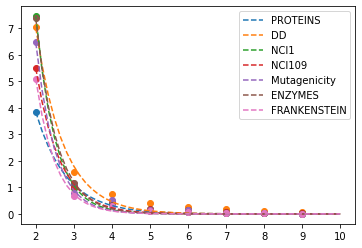

In [53]:
from scipy import optimize
from scipy.special import gamma
from sklearn.metrics import  r2_score,mean_squared_error

def density_func(x,alpha,beta):
    return beta*np.exp(-alpha*x)

for i,name in enumerate(['PROTEINS','DD','NCI1','NCI109','Mutagenicity','ENZYMES','FRANKENSTEIN']):
    params, params_covariance = optimize.curve_fit(
                                                    density_func, 
                                                   np.array(range(2,10)), 
                                                   np.array(entropy_diffs[name]), 
                                                   p0=[0.5,0.5]
                                                  )

    x=np.array(range(2,10))
    plt.scatter(x,entropy_diffs[name],c='C{}'.format(i))

    x=np.linspace(2,10,50)
    y=density_func(x,params[0],params[1])
    plt.plot(x,y,c='C{}'.format(i),label=name,linestyle='--')
    plt.legend()
    
    y_pred=density_func(np.array(range(2,10)),params[0],params[1])
    y_true=np.array(entropy_diffs[name])
    r2=r2_score(y_true,y_pred)
    mse=mean_squared_error(y_true,y_pred)
    print('{}:\t{:.4f},\t{:.4f},\t{:.4f},\t{:.4f}'.format(name,r2,mse,params[0],params[1]))
#     plt.show()

In [49]:
params_covariance

array([[1.46366372e-02, 6.95810268e+00],
       [6.95810268e+00, 3.32608736e+03]])